# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=False)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        # 【bs,c_in,h,w】
        out = F.relu6(self.bn1(self.conv1(x)))
        # 【bs,c_in,h,w】,if stride==1,else 【bs,c_in,h/2,w/2】
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(out,out.shape[-1])  #最好在初始化层定义好
        # 【bs,c_in,1,1】
        
        
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]

        
        #---------------------------- 种子向量策略 -----------------------
        # 随机产生一个标量值
        a=torch.randn(1)*0.1
        print_prob=0.38  # 控制显示tensor信息的概率
        
        # 策略1: 最简单直接的策略
        w=w[0]
    
    
        # 策略2: 在小范围内随机挑选
#         b=int(a*10)
#         if b>0:
#             w=w[b]
#         else:
#             w=w[0]
        
    
        # 策略3：减去均值
        #w=w[0]-torch.mean(w[0])
        
        
        # 策略4: 做标准化或者softmax归一化
        #
        
        # 策略5:对这批数据取平均 且保留第0维
        #w= w.mean(dim=0,keepdim=True)
        
        
        # 策略6：随机产生w值
        #w=torch.randn(w[0].shape).cuda()*1
        
        
        # 策略7: 使用固定种子向量
        #
        
        if a>print_prob:
            print("---"*10)
            print("before autoscale:",w.shape)
            print(w[0:10])
            
        
        w=w.view(1,1,in_channel) # 改变格式
        
        w=self.scaleLayer(w)  #自动缩放层 可以激活或者不激活 甚至采用多级缩放
        
        if a>print_prob:
            print("autoScale weight:",self.scaleLayer.weight)
            print("autoScale bias:",self.scaleLayer.bias)
            
            print("after autoscale w[0]:",w.shape)
            print(w[0:10])
            print("---"*10)
        
        
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        if a>print_prob:
            print("==="*10)
            print("conv1D weight[0]:",self.conv1D.weight[0])
            print("conv1D bias[0]:",self.conv1D.bias)
        
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        if a>print_prob:
            print("after conv1D w[0]:",w.shape)
            print(w[0][0:15])
            print("==="*10)
        
        #--------------------通过非线性激活函数-----------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>print_prob:
            print(w.shape)
            print(w[0][0:20])
            
        # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out




class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.336344, Accuracy: 8.98
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.376990, Accuracy: 10.55
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.319052, Accuracy: 14.65
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.350706, Accuracy: 10.55
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.360566, Accuracy: 10.35
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.316635, Accuracy: 10.74
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.235941, Accuracy: 14.45
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.179312, Accuracy: 18.55
Train Epoch: 0 [20480/50000 (45%)]	Loss: 2.301983, Accuracy: 14.65
Train Epoch: 0 [23040/50000 (51%)]	Loss: 2.202751, Accuracy: 14.65
Train Epoch: 0 [25600/50000 (57%)]	Loss: 2.071144, Accuracy: 19.14
Train Epoch: 0 [28160/50000 (62%)]	Loss: 2.379745, Accuracy: 11.33
Train Epoch: 0 [30720/50000 (68%)]	Loss: 2.077622, Accuracy: 18.36
Train Epoch: 0 [33280/50000 (74%)]	Loss: 2.047662, Accuracy: 20.12
Train Epoch: 0 [35840/50000 (80%)]	Loss: 2.011800, Accuracy: 24.22
Train

Train Epoch: 4 [38400/50000 (85%)]	Loss: 1.237639, Accuracy: 58.20
Train Epoch: 4 [40960/50000 (91%)]	Loss: 1.247834, Accuracy: 56.45
Train Epoch: 4 [43520/50000 (97%)]	Loss: 1.152496, Accuracy: 57.23

Validation set: Average loss: 3.9470, Accuracy: 978/5000 (19.00%)

the time of this epoch:[37.43326783180237 s]
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.138427, Accuracy: 59.57
Train Epoch: 5 [2560/50000 (6%)]	Loss: 1.098218, Accuracy: 59.77
Train Epoch: 5 [5120/50000 (11%)]	Loss: 1.125679, Accuracy: 59.38
Train Epoch: 5 [7680/50000 (17%)]	Loss: 1.112314, Accuracy: 60.74
Train Epoch: 5 [10240/50000 (23%)]	Loss: 1.134493, Accuracy: 59.57
Train Epoch: 5 [12800/50000 (28%)]	Loss: 1.157100, Accuracy: 58.98
Train Epoch: 5 [15360/50000 (34%)]	Loss: 1.164323, Accuracy: 58.20
Train Epoch: 5 [17920/50000 (40%)]	Loss: 1.110806, Accuracy: 61.91
Train Epoch: 5 [20480/50000 (45%)]	Loss: 1.088003, Accuracy: 62.50
Train Epoch: 5 [23040/50000 (51%)]	Loss: 1.115650, Accuracy: 61.33
Train Epoch: 5 [25600/500


Test set: Average loss: 4.6254, Accuracy: 3420/10000 (34.20%)

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.652714, Accuracy: 77.34
Train Epoch: 11 [2560/50000 (6%)]	Loss: 0.664620, Accuracy: 79.10
Train Epoch: 11 [5120/50000 (11%)]	Loss: 0.684365, Accuracy: 73.05
Train Epoch: 11 [7680/50000 (17%)]	Loss: 0.709286, Accuracy: 73.44
Train Epoch: 11 [10240/50000 (23%)]	Loss: 0.695239, Accuracy: 76.17
Train Epoch: 11 [12800/50000 (28%)]	Loss: 0.710593, Accuracy: 75.59
Train Epoch: 11 [15360/50000 (34%)]	Loss: 0.660761, Accuracy: 79.10
Train Epoch: 11 [17920/50000 (40%)]	Loss: 0.645172, Accuracy: 77.93
Train Epoch: 11 [20480/50000 (45%)]	Loss: 0.732022, Accuracy: 74.41
Train Epoch: 11 [23040/50000 (51%)]	Loss: 0.638008, Accuracy: 76.95
Train Epoch: 11 [25600/50000 (57%)]	Loss: 0.712096, Accuracy: 74.22
Train Epoch: 11 [28160/50000 (62%)]	Loss: 0.688273, Accuracy: 74.80
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.629035, Accuracy: 78.52
Train Epoch: 11 [33280/50000 (74%)]	Loss: 0.617063, Accuracy:

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.429182, Accuracy: 84.77
Train Epoch: 17 [2560/50000 (6%)]	Loss: 0.477021, Accuracy: 83.40
Train Epoch: 17 [5120/50000 (11%)]	Loss: 0.439409, Accuracy: 85.16
Train Epoch: 17 [7680/50000 (17%)]	Loss: 0.418902, Accuracy: 85.94
Train Epoch: 17 [10240/50000 (23%)]	Loss: 0.418751, Accuracy: 85.35
Train Epoch: 17 [12800/50000 (28%)]	Loss: 0.491937, Accuracy: 82.23
Train Epoch: 17 [15360/50000 (34%)]	Loss: 0.527079, Accuracy: 82.62
Train Epoch: 17 [17920/50000 (40%)]	Loss: 0.459881, Accuracy: 84.38
Train Epoch: 17 [20480/50000 (45%)]	Loss: 0.424927, Accuracy: 84.57
Train Epoch: 17 [23040/50000 (51%)]	Loss: 0.485190, Accuracy: 82.81
Train Epoch: 17 [25600/50000 (57%)]	Loss: 0.430929, Accuracy: 85.94
Train Epoch: 17 [28160/50000 (62%)]	Loss: 0.479006, Accuracy: 84.96
Train Epoch: 17 [30720/50000 (68%)]	Loss: 0.387846, Accuracy: 86.33
Train Epoch: 17 [33280/50000 (74%)]	Loss: 0.481013, Accuracy: 83.98
Train Epoch: 17 [35840/50000 (80%)]	Loss: 0.442207, Accur


Test set: Average loss: 1.7798, Accuracy: 5444/10000 (54.44%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.390903, Accuracy: 86.52
Train Epoch: 21 [2560/50000 (6%)]	Loss: 0.355655, Accuracy: 87.11
Train Epoch: 21 [5120/50000 (11%)]	Loss: 0.400784, Accuracy: 88.09
Train Epoch: 21 [7680/50000 (17%)]	Loss: 0.377369, Accuracy: 85.55
Train Epoch: 21 [10240/50000 (23%)]	Loss: 0.384346, Accuracy: 87.11
Train Epoch: 21 [12800/50000 (28%)]	Loss: 0.407466, Accuracy: 85.94
Train Epoch: 21 [15360/50000 (34%)]	Loss: 0.333182, Accuracy: 88.09
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.352597, Accuracy: 89.06
Train Epoch: 21 [20480/50000 (45%)]	Loss: 0.315494, Accuracy: 89.26
Train Epoch: 21 [23040/50000 (51%)]	Loss: 0.340737, Accuracy: 90.04
Train Epoch: 21 [25600/50000 (57%)]	Loss: 0.377643, Accuracy: 86.33
Train Epoch: 21 [28160/50000 (62%)]	Loss: 0.438331, Accuracy: 84.77
Train Epoch: 21 [30720/50000 (68%)]	Loss: 0.389150, Accuracy: 88.48
Train Epoch: 21 [33280/50000 (74%)]	Loss: 0.352487, Accuracy:

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.297656, Accuracy: 89.84
Train Epoch: 27 [2560/50000 (6%)]	Loss: 0.270648, Accuracy: 91.80
Train Epoch: 27 [5120/50000 (11%)]	Loss: 0.337377, Accuracy: 88.28
Train Epoch: 27 [7680/50000 (17%)]	Loss: 0.341374, Accuracy: 88.09
Train Epoch: 27 [10240/50000 (23%)]	Loss: 0.265822, Accuracy: 91.60
Train Epoch: 27 [12800/50000 (28%)]	Loss: 0.287002, Accuracy: 90.04
Train Epoch: 27 [15360/50000 (34%)]	Loss: 0.339891, Accuracy: 88.87
Train Epoch: 27 [17920/50000 (40%)]	Loss: 0.336777, Accuracy: 88.09
Train Epoch: 27 [20480/50000 (45%)]	Loss: 0.389714, Accuracy: 85.74
Train Epoch: 27 [23040/50000 (51%)]	Loss: 0.301421, Accuracy: 89.84
Train Epoch: 27 [25600/50000 (57%)]	Loss: 0.314185, Accuracy: 89.45
Train Epoch: 27 [28160/50000 (62%)]	Loss: 0.364305, Accuracy: 87.11
Train Epoch: 27 [30720/50000 (68%)]	Loss: 0.371844, Accuracy: 87.70
Train Epoch: 27 [33280/50000 (74%)]	Loss: 0.414499, Accuracy: 84.38
Train Epoch: 27 [35840/50000 (80%)]	Loss: 0.380776, Accur

Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.309581, Accuracy: 89.84
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.296906, Accuracy: 89.06
Train Epoch: 33 [7680/50000 (17%)]	Loss: 0.292935, Accuracy: 89.06
Train Epoch: 33 [10240/50000 (23%)]	Loss: 0.274679, Accuracy: 90.43
Train Epoch: 33 [12800/50000 (28%)]	Loss: 0.284844, Accuracy: 89.45
Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.322446, Accuracy: 88.87
Train Epoch: 33 [17920/50000 (40%)]	Loss: 0.260226, Accuracy: 92.19
Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.273169, Accuracy: 90.43
Train Epoch: 33 [23040/50000 (51%)]	Loss: 0.380678, Accuracy: 87.50
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.293741, Accuracy: 89.45
Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.345073, Accuracy: 88.28
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.333730, Accuracy: 89.26
Train Epoch: 33 [33280/50000 (74%)]	Loss: 0.314881, Accuracy: 89.84
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.269047, Accuracy: 91.21
Train Epoch: 33 [38400/50000 (85%)]	Loss: 0.291617, 


Validation set: Average loss: 1.9603, Accuracy: 2529/5000 (50.00%)

the time of this epoch:[38.9338538646698 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.291750, Accuracy: 90.62
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.274418, Accuracy: 91.80
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.261432, Accuracy: 91.02
Train Epoch: 36 [7680/50000 (17%)]	Loss: 0.250964, Accuracy: 91.41
Train Epoch: 36 [10240/50000 (23%)]	Loss: 0.360120, Accuracy: 89.45
Train Epoch: 36 [12800/50000 (28%)]	Loss: 0.248869, Accuracy: 90.82
Train Epoch: 36 [15360/50000 (34%)]	Loss: 0.321396, Accuracy: 87.89
Train Epoch: 36 [17920/50000 (40%)]	Loss: 0.331538, Accuracy: 89.45
Train Epoch: 36 [20480/50000 (45%)]	Loss: 0.386341, Accuracy: 87.50
Train Epoch: 36 [23040/50000 (51%)]	Loss: 0.308836, Accuracy: 90.04
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.246571, Accuracy: 90.62
Train Epoch: 36 [28160/50000 (62%)]	Loss: 0.349726, Accuracy: 89.26
Train Epoch: 36 [30720/50000 (68%)]	Loss: 0.284181, Accuracy: 90.43
Train Epoch:

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.250382, Accuracy: 91.41
Train Epoch: 42 [2560/50000 (6%)]	Loss: 0.267630, Accuracy: 91.80
Train Epoch: 42 [5120/50000 (11%)]	Loss: 0.355480, Accuracy: 87.70
Train Epoch: 42 [7680/50000 (17%)]	Loss: 0.230709, Accuracy: 91.99
Train Epoch: 42 [10240/50000 (23%)]	Loss: 0.263617, Accuracy: 92.77
Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.245998, Accuracy: 91.80
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.247542, Accuracy: 91.21
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.258517, Accuracy: 90.62
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.247924, Accuracy: 92.38
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.278645, Accuracy: 89.26
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.261265, Accuracy: 92.19
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.284159, Accuracy: 91.41
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.257122, Accuracy: 91.80
Train Epoch: 42 [33280/50000 (74%)]	Loss: 0.306357, Accuracy: 90.23
Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.260161, Accur

Train Epoch: 48 [2560/50000 (6%)]	Loss: 0.241858, Accuracy: 91.99
Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.239063, Accuracy: 92.38
Train Epoch: 48 [7680/50000 (17%)]	Loss: 0.264350, Accuracy: 91.02
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.289782, Accuracy: 89.84
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.292412, Accuracy: 89.65
Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.209965, Accuracy: 93.36
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.236119, Accuracy: 90.82
Train Epoch: 48 [20480/50000 (45%)]	Loss: 0.254522, Accuracy: 91.41
Train Epoch: 48 [23040/50000 (51%)]	Loss: 0.234620, Accuracy: 91.80
Train Epoch: 48 [25600/50000 (57%)]	Loss: 0.236416, Accuracy: 91.41
Train Epoch: 48 [28160/50000 (62%)]	Loss: 0.255361, Accuracy: 90.82
Train Epoch: 48 [30720/50000 (68%)]	Loss: 0.246539, Accuracy: 91.21
Train Epoch: 48 [33280/50000 (74%)]	Loss: 0.294043, Accuracy: 89.65
Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.258401, Accuracy: 91.21
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.264855, 

Train Epoch: 54 [0/50000 (0%)]	Loss: 0.274261, Accuracy: 91.21
Train Epoch: 54 [2560/50000 (6%)]	Loss: 0.184618, Accuracy: 93.36
Train Epoch: 54 [5120/50000 (11%)]	Loss: 0.267924, Accuracy: 91.21
Train Epoch: 54 [7680/50000 (17%)]	Loss: 0.283890, Accuracy: 91.41
Train Epoch: 54 [10240/50000 (23%)]	Loss: 0.239126, Accuracy: 91.21
Train Epoch: 54 [12800/50000 (28%)]	Loss: 0.212529, Accuracy: 93.95
Train Epoch: 54 [15360/50000 (34%)]	Loss: 0.269323, Accuracy: 91.80
Train Epoch: 54 [17920/50000 (40%)]	Loss: 0.301041, Accuracy: 91.41
Train Epoch: 54 [20480/50000 (45%)]	Loss: 0.255673, Accuracy: 90.43
Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.283988, Accuracy: 90.62
Train Epoch: 54 [25600/50000 (57%)]	Loss: 0.270693, Accuracy: 91.21
Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.288442, Accuracy: 89.26
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.268029, Accuracy: 91.21
Train Epoch: 54 [33280/50000 (74%)]	Loss: 0.302758, Accuracy: 89.45
Train Epoch: 54 [35840/50000 (80%)]	Loss: 0.240904, Accur


Test set: Average loss: 3.8159, Accuracy: 1331/10000 (13.31%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.282766, Accuracy: 91.02
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.194701, Accuracy: 94.34
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.221152, Accuracy: 92.77
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.200402, Accuracy: 93.75
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.235327, Accuracy: 93.16
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.225638, Accuracy: 90.43
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.224108, Accuracy: 92.77
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.205645, Accuracy: 93.55
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.246684, Accuracy: 91.41
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.302204, Accuracy: 88.67
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.266676, Accuracy: 91.21
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.227943, Accuracy: 92.38
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.307903, Accuracy: 89.45
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.269146, Accuracy:

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.240184, Accuracy: 92.38
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.268245, Accuracy: 90.23
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.259832, Accuracy: 90.62
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.187397, Accuracy: 93.16
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.247539, Accuracy: 90.43
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.232223, Accuracy: 92.97
Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.250509, Accuracy: 91.60
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.184537, Accuracy: 93.95
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.200582, Accuracy: 94.34
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.232862, Accuracy: 91.80
Train Epoch: 61 [25600/50000 (57%)]	Loss: 0.297687, Accuracy: 89.65
Train Epoch: 61 [28160/50000 (62%)]	Loss: 0.227604, Accuracy: 92.97
Train Epoch: 61 [30720/50000 (68%)]	Loss: 0.269419, Accuracy: 90.04
Train Epoch: 61 [33280/50000 (74%)]	Loss: 0.216872, Accuracy: 91.60
Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.215558, Accur

Train Epoch: 67 [2560/50000 (6%)]	Loss: 0.266276, Accuracy: 90.04
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.250190, Accuracy: 90.23
Train Epoch: 67 [7680/50000 (17%)]	Loss: 0.195729, Accuracy: 93.55
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.206032, Accuracy: 92.97
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.211601, Accuracy: 93.16
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.285170, Accuracy: 90.82
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.300833, Accuracy: 90.23
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.235029, Accuracy: 90.23
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.253074, Accuracy: 91.41
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.175729, Accuracy: 92.97
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.284138, Accuracy: 90.82
Train Epoch: 67 [30720/50000 (68%)]	Loss: 0.200132, Accuracy: 92.77
Train Epoch: 67 [33280/50000 (74%)]	Loss: 0.234356, Accuracy: 93.16
Train Epoch: 67 [35840/50000 (80%)]	Loss: 0.321839, Accuracy: 89.26
Train Epoch: 67 [38400/50000 (85%)]	Loss: 0.269009, 

Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.225899, Accuracy: 93.75
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.215888, Accuracy: 91.80
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.255954, Accuracy: 92.58
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.235664, Accuracy: 91.99
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.249495, Accuracy: 91.02
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.231072, Accuracy: 91.99
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.155238, Accuracy: 95.31
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.214593, Accuracy: 92.77
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.204324, Accuracy: 92.38
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.232731, Accuracy: 92.19
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.201539, Accuracy: 92.97
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.249573, Accuracy: 91.80
Train Epoch: 73 [35840/50000 (80%)]	Loss: 0.232559, Accuracy: 91.41
Train Epoch: 73 [38400/50000 (85%)]	Loss: 0.267714, Accuracy: 91.60
Train Epoch: 73 [40960/50000 (91%)]	Loss: 0.217030

Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.209316, Accuracy: 92.77
Train Epoch: 77 [43520/50000 (97%)]	Loss: 0.227918, Accuracy: 90.82

Validation set: Average loss: 0.8732, Accuracy: 3671/5000 (73.00%)

the time of this epoch:[39.083820819854736 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.219089, Accuracy: 93.16
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.153100, Accuracy: 95.12
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.260058, Accuracy: 92.38
Train Epoch: 78 [7680/50000 (17%)]	Loss: 0.259870, Accuracy: 92.19
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.221652, Accuracy: 92.38
Train Epoch: 78 [12800/50000 (28%)]	Loss: 0.244000, Accuracy: 92.38
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.250930, Accuracy: 91.02
Train Epoch: 78 [17920/50000 (40%)]	Loss: 0.206689, Accuracy: 92.97
Train Epoch: 78 [20480/50000 (45%)]	Loss: 0.255020, Accuracy: 89.45
Train Epoch: 78 [23040/50000 (51%)]	Loss: 0.186677, Accuracy: 93.36
Train Epoch: 78 [25600/50000 (57%)]	Loss: 0.247514, Accuracy: 91.21
Train Epoc

Train Epoch: 83 [17920/50000 (40%)]	Loss: 0.237835, Accuracy: 91.99
Train Epoch: 83 [20480/50000 (45%)]	Loss: 0.202850, Accuracy: 92.19
Train Epoch: 83 [23040/50000 (51%)]	Loss: 0.200230, Accuracy: 94.53
Train Epoch: 83 [25600/50000 (57%)]	Loss: 0.266039, Accuracy: 89.84
Train Epoch: 83 [28160/50000 (62%)]	Loss: 0.240357, Accuracy: 92.97
Train Epoch: 83 [30720/50000 (68%)]	Loss: 0.227390, Accuracy: 92.97
Train Epoch: 83 [33280/50000 (74%)]	Loss: 0.202135, Accuracy: 92.19
Train Epoch: 83 [35840/50000 (80%)]	Loss: 0.289136, Accuracy: 90.04
Train Epoch: 83 [38400/50000 (85%)]	Loss: 0.194868, Accuracy: 92.58
Train Epoch: 83 [40960/50000 (91%)]	Loss: 0.199867, Accuracy: 92.97
Train Epoch: 83 [43520/50000 (97%)]	Loss: 0.234771, Accuracy: 90.62

Validation set: Average loss: 0.5740, Accuracy: 4169/5000 (83.00%)

the time of this epoch:[38.969828605651855 s]
Train Epoch: 84 [0/50000 (0%)]	Loss: 0.211602, Accuracy: 93.16
Train Epoch: 84 [2560/50000 (6%)]	Loss: 0.213811, Accuracy: 93.36
Train Ep

Train Epoch: 89 [20480/50000 (45%)]	Loss: 0.250230, Accuracy: 92.19
Train Epoch: 89 [23040/50000 (51%)]	Loss: 0.201088, Accuracy: 92.58
Train Epoch: 89 [25600/50000 (57%)]	Loss: 0.186781, Accuracy: 92.19
Train Epoch: 89 [28160/50000 (62%)]	Loss: 0.232962, Accuracy: 91.80
Train Epoch: 89 [30720/50000 (68%)]	Loss: 0.254465, Accuracy: 90.04
Train Epoch: 89 [33280/50000 (74%)]	Loss: 0.253647, Accuracy: 92.58
Train Epoch: 89 [35840/50000 (80%)]	Loss: 0.214275, Accuracy: 91.99
Train Epoch: 89 [38400/50000 (85%)]	Loss: 0.220727, Accuracy: 91.80
Train Epoch: 89 [40960/50000 (91%)]	Loss: 0.183983, Accuracy: 93.95
Train Epoch: 89 [43520/50000 (97%)]	Loss: 0.208915, Accuracy: 92.38

Validation set: Average loss: 0.9159, Accuracy: 3883/5000 (77.00%)

the time of this epoch:[38.59506678581238 s]
Train Epoch: 90 [0/50000 (0%)]	Loss: 0.195593, Accuracy: 92.77
Train Epoch: 90 [2560/50000 (6%)]	Loss: 0.146074, Accuracy: 95.12
Train Epoch: 90 [5120/50000 (11%)]	Loss: 0.228895, Accuracy: 91.21
Train Epoc


Test set: Average loss: 6.7952, Accuracy: 1606/10000 (16.06%)

Train Epoch: 91 [0/50000 (0%)]	Loss: 0.198038, Accuracy: 93.36
Train Epoch: 91 [2560/50000 (6%)]	Loss: 0.230065, Accuracy: 91.99
Train Epoch: 91 [5120/50000 (11%)]	Loss: 0.179815, Accuracy: 92.97
Train Epoch: 91 [7680/50000 (17%)]	Loss: 0.244953, Accuracy: 90.82
Train Epoch: 91 [10240/50000 (23%)]	Loss: 0.246563, Accuracy: 91.80
Train Epoch: 91 [12800/50000 (28%)]	Loss: 0.252733, Accuracy: 91.21
Train Epoch: 91 [15360/50000 (34%)]	Loss: 0.201588, Accuracy: 94.14
Train Epoch: 91 [17920/50000 (40%)]	Loss: 0.191381, Accuracy: 93.16
Train Epoch: 91 [20480/50000 (45%)]	Loss: 0.254804, Accuracy: 90.62
Train Epoch: 91 [23040/50000 (51%)]	Loss: 0.212273, Accuracy: 92.19
Train Epoch: 91 [25600/50000 (57%)]	Loss: 0.276620, Accuracy: 89.84
Train Epoch: 91 [28160/50000 (62%)]	Loss: 0.272824, Accuracy: 90.82
Train Epoch: 91 [30720/50000 (68%)]	Loss: 0.218700, Accuracy: 92.97
Train Epoch: 91 [33280/50000 (74%)]	Loss: 0.214700, Accuracy:

Train Epoch: 97 [0/50000 (0%)]	Loss: 0.188772, Accuracy: 94.14
Train Epoch: 97 [2560/50000 (6%)]	Loss: 0.185630, Accuracy: 94.14
Train Epoch: 97 [5120/50000 (11%)]	Loss: 0.203214, Accuracy: 92.58
Train Epoch: 97 [7680/50000 (17%)]	Loss: 0.170407, Accuracy: 94.73
Train Epoch: 97 [10240/50000 (23%)]	Loss: 0.239248, Accuracy: 91.21
Train Epoch: 97 [12800/50000 (28%)]	Loss: 0.175136, Accuracy: 94.34
Train Epoch: 97 [15360/50000 (34%)]	Loss: 0.194957, Accuracy: 93.95
Train Epoch: 97 [17920/50000 (40%)]	Loss: 0.249070, Accuracy: 91.41
Train Epoch: 97 [20480/50000 (45%)]	Loss: 0.240677, Accuracy: 92.19
Train Epoch: 97 [23040/50000 (51%)]	Loss: 0.263612, Accuracy: 90.23
Train Epoch: 97 [25600/50000 (57%)]	Loss: 0.210782, Accuracy: 92.19
Train Epoch: 97 [28160/50000 (62%)]	Loss: 0.238404, Accuracy: 92.19
Train Epoch: 97 [30720/50000 (68%)]	Loss: 0.192967, Accuracy: 93.95
Train Epoch: 97 [33280/50000 (74%)]	Loss: 0.286507, Accuracy: 90.82
Train Epoch: 97 [35840/50000 (80%)]	Loss: 0.210676, Accur

Train Epoch: 100 [0/50000 (0%)]	Loss: 0.182681, Accuracy: 93.75
Train Epoch: 100 [2560/50000 (6%)]	Loss: 0.207700, Accuracy: 92.77
Train Epoch: 100 [5120/50000 (11%)]	Loss: 0.214505, Accuracy: 92.19
Train Epoch: 100 [7680/50000 (17%)]	Loss: 0.215277, Accuracy: 91.41
Train Epoch: 100 [10240/50000 (23%)]	Loss: 0.250784, Accuracy: 91.99
Train Epoch: 100 [12800/50000 (28%)]	Loss: 0.222409, Accuracy: 93.16
Train Epoch: 100 [15360/50000 (34%)]	Loss: 0.236921, Accuracy: 92.38
Train Epoch: 100 [17920/50000 (40%)]	Loss: 0.219570, Accuracy: 92.58
Train Epoch: 100 [20480/50000 (45%)]	Loss: 0.262855, Accuracy: 89.84
Train Epoch: 100 [23040/50000 (51%)]	Loss: 0.215849, Accuracy: 91.99
Train Epoch: 100 [25600/50000 (57%)]	Loss: 0.225976, Accuracy: 91.60
Train Epoch: 100 [28160/50000 (62%)]	Loss: 0.270879, Accuracy: 90.23
Train Epoch: 100 [30720/50000 (68%)]	Loss: 0.187498, Accuracy: 92.77
Train Epoch: 100 [33280/50000 (74%)]	Loss: 0.234768, Accuracy: 92.38
Train Epoch: 100 [35840/50000 (80%)]	Loss: 

Train Epoch: 106 [0/50000 (0%)]	Loss: 0.193521, Accuracy: 93.75
Train Epoch: 106 [2560/50000 (6%)]	Loss: 0.218159, Accuracy: 91.41
Train Epoch: 106 [5120/50000 (11%)]	Loss: 0.203970, Accuracy: 92.77
Train Epoch: 106 [7680/50000 (17%)]	Loss: 0.181449, Accuracy: 93.36
Train Epoch: 106 [10240/50000 (23%)]	Loss: 0.205267, Accuracy: 93.16
Train Epoch: 106 [12800/50000 (28%)]	Loss: 0.183396, Accuracy: 94.14
Train Epoch: 106 [15360/50000 (34%)]	Loss: 0.190752, Accuracy: 93.95
Train Epoch: 106 [17920/50000 (40%)]	Loss: 0.235897, Accuracy: 91.99
Train Epoch: 106 [20480/50000 (45%)]	Loss: 0.229540, Accuracy: 91.99
Train Epoch: 106 [23040/50000 (51%)]	Loss: 0.189548, Accuracy: 91.99
Train Epoch: 106 [25600/50000 (57%)]	Loss: 0.220247, Accuracy: 93.16
Train Epoch: 106 [28160/50000 (62%)]	Loss: 0.263440, Accuracy: 90.43
Train Epoch: 106 [30720/50000 (68%)]	Loss: 0.219523, Accuracy: 92.97
Train Epoch: 106 [33280/50000 (74%)]	Loss: 0.253258, Accuracy: 91.41
Train Epoch: 106 [35840/50000 (80%)]	Loss: 


Test set: Average loss: 0.7981, Accuracy: 7719/10000 (77.19%)

Train Epoch: 111 [0/50000 (0%)]	Loss: 0.201481, Accuracy: 93.16
Train Epoch: 111 [2560/50000 (6%)]	Loss: 0.192773, Accuracy: 92.97
Train Epoch: 111 [5120/50000 (11%)]	Loss: 0.165734, Accuracy: 94.53
Train Epoch: 111 [7680/50000 (17%)]	Loss: 0.231122, Accuracy: 91.41
Train Epoch: 111 [10240/50000 (23%)]	Loss: 0.193555, Accuracy: 92.77
Train Epoch: 111 [12800/50000 (28%)]	Loss: 0.260915, Accuracy: 90.04
Train Epoch: 111 [15360/50000 (34%)]	Loss: 0.217302, Accuracy: 93.55
Train Epoch: 111 [17920/50000 (40%)]	Loss: 0.186585, Accuracy: 94.34
Train Epoch: 111 [20480/50000 (45%)]	Loss: 0.180593, Accuracy: 93.75
Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.284832, Accuracy: 88.87
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.208710, Accuracy: 93.16
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.205015, Accuracy: 93.55
Train Epoch: 111 [30720/50000 (68%)]	Loss: 0.190390, Accuracy: 93.55
Train Epoch: 111 [33280/50000 (74%)]	Loss: 0.228


Test set: Average loss: 0.8117, Accuracy: 7907/10000 (79.07%)

Train Epoch: 117 [0/50000 (0%)]	Loss: 0.228499, Accuracy: 92.38
Train Epoch: 117 [2560/50000 (6%)]	Loss: 0.199648, Accuracy: 93.55
Train Epoch: 117 [5120/50000 (11%)]	Loss: 0.272612, Accuracy: 90.23
Train Epoch: 117 [7680/50000 (17%)]	Loss: 0.209632, Accuracy: 93.75
Train Epoch: 117 [10240/50000 (23%)]	Loss: 0.236274, Accuracy: 92.19
Train Epoch: 117 [12800/50000 (28%)]	Loss: 0.191671, Accuracy: 92.97
Train Epoch: 117 [15360/50000 (34%)]	Loss: 0.206545, Accuracy: 92.58
Train Epoch: 117 [17920/50000 (40%)]	Loss: 0.186985, Accuracy: 93.55
Train Epoch: 117 [20480/50000 (45%)]	Loss: 0.208854, Accuracy: 92.97
Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.202225, Accuracy: 93.75
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.180187, Accuracy: 94.14
Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.246569, Accuracy: 90.23
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.238879, Accuracy: 91.80
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.233


Test set: Average loss: 0.7835, Accuracy: 7847/10000 (78.47%)

Train Epoch: 123 [0/50000 (0%)]	Loss: 0.177405, Accuracy: 93.75
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.187218, Accuracy: 91.99
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.183287, Accuracy: 93.36
Train Epoch: 123 [7680/50000 (17%)]	Loss: 0.156021, Accuracy: 94.14
Train Epoch: 123 [10240/50000 (23%)]	Loss: 0.250369, Accuracy: 91.80
Train Epoch: 123 [12800/50000 (28%)]	Loss: 0.215745, Accuracy: 92.77
Train Epoch: 123 [15360/50000 (34%)]	Loss: 0.201819, Accuracy: 92.77
Train Epoch: 123 [17920/50000 (40%)]	Loss: 0.225762, Accuracy: 91.99
Train Epoch: 123 [20480/50000 (45%)]	Loss: 0.208800, Accuracy: 93.36
Train Epoch: 123 [23040/50000 (51%)]	Loss: 0.211349, Accuracy: 92.97
Train Epoch: 123 [25600/50000 (57%)]	Loss: 0.253688, Accuracy: 90.43
Train Epoch: 123 [28160/50000 (62%)]	Loss: 0.200882, Accuracy: 93.95
Train Epoch: 123 [30720/50000 (68%)]	Loss: 0.214907, Accuracy: 93.36
Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.216


Test set: Average loss: 0.8799, Accuracy: 7628/10000 (76.28%)

Train Epoch: 129 [0/50000 (0%)]	Loss: 0.210928, Accuracy: 91.99
Train Epoch: 129 [2560/50000 (6%)]	Loss: 0.144291, Accuracy: 95.12
Train Epoch: 129 [5120/50000 (11%)]	Loss: 0.150268, Accuracy: 93.36
Train Epoch: 129 [7680/50000 (17%)]	Loss: 0.197600, Accuracy: 93.36
Train Epoch: 129 [10240/50000 (23%)]	Loss: 0.207226, Accuracy: 93.16
Train Epoch: 129 [12800/50000 (28%)]	Loss: 0.152083, Accuracy: 94.73
Train Epoch: 129 [15360/50000 (34%)]	Loss: 0.230889, Accuracy: 92.19
Train Epoch: 129 [17920/50000 (40%)]	Loss: 0.243558, Accuracy: 92.19
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.250377, Accuracy: 91.80
Train Epoch: 129 [23040/50000 (51%)]	Loss: 0.226221, Accuracy: 92.19
Train Epoch: 129 [25600/50000 (57%)]	Loss: 0.207151, Accuracy: 93.55
Train Epoch: 129 [28160/50000 (62%)]	Loss: 0.265645, Accuracy: 91.21
Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.178020, Accuracy: 93.95
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.203

Train Epoch: 133 [17920/50000 (40%)]	Loss: 0.170587, Accuracy: 93.55
Train Epoch: 133 [20480/50000 (45%)]	Loss: 0.196140, Accuracy: 92.19
Train Epoch: 133 [23040/50000 (51%)]	Loss: 0.215373, Accuracy: 91.99
Train Epoch: 133 [25600/50000 (57%)]	Loss: 0.200000, Accuracy: 94.14
Train Epoch: 133 [28160/50000 (62%)]	Loss: 0.286449, Accuracy: 90.43
Train Epoch: 133 [30720/50000 (68%)]	Loss: 0.195065, Accuracy: 93.16
Train Epoch: 133 [33280/50000 (74%)]	Loss: 0.156871, Accuracy: 95.31
Train Epoch: 133 [35840/50000 (80%)]	Loss: 0.166145, Accuracy: 93.75
Train Epoch: 133 [38400/50000 (85%)]	Loss: 0.232522, Accuracy: 92.19
Train Epoch: 133 [40960/50000 (91%)]	Loss: 0.203353, Accuracy: 94.14
Train Epoch: 133 [43520/50000 (97%)]	Loss: 0.233385, Accuracy: 92.58

Validation set: Average loss: 0.6311, Accuracy: 4094/5000 (81.00%)

the time of this epoch:[38.48120188713074 s]
Train Epoch: 134 [0/50000 (0%)]	Loss: 0.201566, Accuracy: 91.99
Train Epoch: 134 [2560/50000 (6%)]	Loss: 0.162186, Accuracy: 94

Train Epoch: 139 [15360/50000 (34%)]	Loss: 0.182507, Accuracy: 94.14
Train Epoch: 139 [17920/50000 (40%)]	Loss: 0.188391, Accuracy: 94.53
Train Epoch: 139 [20480/50000 (45%)]	Loss: 0.269184, Accuracy: 90.62
Train Epoch: 139 [23040/50000 (51%)]	Loss: 0.261026, Accuracy: 90.82
Train Epoch: 139 [25600/50000 (57%)]	Loss: 0.221002, Accuracy: 90.82
Train Epoch: 139 [28160/50000 (62%)]	Loss: 0.217815, Accuracy: 91.80
Train Epoch: 139 [30720/50000 (68%)]	Loss: 0.192677, Accuracy: 93.16
Train Epoch: 139 [33280/50000 (74%)]	Loss: 0.216620, Accuracy: 92.19
Train Epoch: 139 [35840/50000 (80%)]	Loss: 0.190240, Accuracy: 92.97
Train Epoch: 139 [38400/50000 (85%)]	Loss: 0.188410, Accuracy: 93.55
Train Epoch: 139 [40960/50000 (91%)]	Loss: 0.263744, Accuracy: 91.80
Train Epoch: 139 [43520/50000 (97%)]	Loss: 0.204308, Accuracy: 92.38

Validation set: Average loss: 0.8149, Accuracy: 3821/5000 (76.00%)

the time of this epoch:[38.3765230178833 s]
Train Epoch: 140 [0/50000 (0%)]	Loss: 0.201581, Accuracy: 9

Train Epoch: 144 [0/50000 (0%)]	Loss: 0.187874, Accuracy: 94.34
Train Epoch: 144 [2560/50000 (6%)]	Loss: 0.230385, Accuracy: 92.38
Train Epoch: 144 [5120/50000 (11%)]	Loss: 0.194239, Accuracy: 93.36
Train Epoch: 144 [7680/50000 (17%)]	Loss: 0.186531, Accuracy: 93.95
Train Epoch: 144 [10240/50000 (23%)]	Loss: 0.221538, Accuracy: 91.99
Train Epoch: 144 [12800/50000 (28%)]	Loss: 0.203281, Accuracy: 92.77
Train Epoch: 144 [15360/50000 (34%)]	Loss: 0.192174, Accuracy: 94.14
Train Epoch: 144 [17920/50000 (40%)]	Loss: 0.194429, Accuracy: 92.58
Train Epoch: 144 [20480/50000 (45%)]	Loss: 0.185794, Accuracy: 93.75
Train Epoch: 144 [23040/50000 (51%)]	Loss: 0.178092, Accuracy: 94.34
Train Epoch: 144 [25600/50000 (57%)]	Loss: 0.206204, Accuracy: 91.99
Train Epoch: 144 [28160/50000 (62%)]	Loss: 0.238176, Accuracy: 91.02
Train Epoch: 144 [30720/50000 (68%)]	Loss: 0.237012, Accuracy: 91.21
Train Epoch: 144 [33280/50000 (74%)]	Loss: 0.191844, Accuracy: 92.58
Train Epoch: 144 [35840/50000 (80%)]	Loss: 


Validation set: Average loss: 0.6497, Accuracy: 4041/5000 (80.00%)

the time of this epoch:[38.69142961502075 s]
Train Epoch: 146 [0/50000 (0%)]	Loss: 0.164448, Accuracy: 93.95
Train Epoch: 146 [2560/50000 (6%)]	Loss: 0.155941, Accuracy: 94.92
Train Epoch: 146 [5120/50000 (11%)]	Loss: 0.227947, Accuracy: 92.58
Train Epoch: 146 [7680/50000 (17%)]	Loss: 0.259557, Accuracy: 91.41
Train Epoch: 146 [10240/50000 (23%)]	Loss: 0.206495, Accuracy: 92.58
Train Epoch: 146 [12800/50000 (28%)]	Loss: 0.192634, Accuracy: 93.16
Train Epoch: 146 [15360/50000 (34%)]	Loss: 0.260633, Accuracy: 90.04
Train Epoch: 146 [17920/50000 (40%)]	Loss: 0.230168, Accuracy: 92.38
Train Epoch: 146 [20480/50000 (45%)]	Loss: 0.148254, Accuracy: 94.34
Train Epoch: 146 [23040/50000 (51%)]	Loss: 0.227852, Accuracy: 92.77
Train Epoch: 146 [25600/50000 (57%)]	Loss: 0.210945, Accuracy: 93.16
Train Epoch: 146 [28160/50000 (62%)]	Loss: 0.213467, Accuracy: 92.97
Train Epoch: 146 [30720/50000 (68%)]	Loss: 0.196103, Accuracy: 93.5

Train Epoch: 151 [43520/50000 (97%)]	Loss: 0.085887, Accuracy: 97.66

Validation set: Average loss: 0.5105, Accuracy: 4216/5000 (84.00%)

the time of this epoch:[38.76736640930176 s]
Train Epoch: 152 [0/50000 (0%)]	Loss: 0.081184, Accuracy: 97.85
Train Epoch: 152 [2560/50000 (6%)]	Loss: 0.087103, Accuracy: 97.66
Train Epoch: 152 [5120/50000 (11%)]	Loss: 0.089252, Accuracy: 97.27
Train Epoch: 152 [7680/50000 (17%)]	Loss: 0.113182, Accuracy: 95.70
Train Epoch: 152 [10240/50000 (23%)]	Loss: 0.086568, Accuracy: 97.66
Train Epoch: 152 [12800/50000 (28%)]	Loss: 0.092068, Accuracy: 97.66
Train Epoch: 152 [15360/50000 (34%)]	Loss: 0.075645, Accuracy: 98.05
Train Epoch: 152 [17920/50000 (40%)]	Loss: 0.067991, Accuracy: 97.66
Train Epoch: 152 [20480/50000 (45%)]	Loss: 0.069839, Accuracy: 97.85
Train Epoch: 152 [23040/50000 (51%)]	Loss: 0.074882, Accuracy: 98.05
Train Epoch: 152 [25600/50000 (57%)]	Loss: 0.070569, Accuracy: 97.46
Train Epoch: 152 [28160/50000 (62%)]	Loss: 0.067619, Accuracy: 97.8


Test set: Average loss: 0.4250, Accuracy: 8741/10000 (87.41%)

Train Epoch: 153 [0/50000 (0%)]	Loss: 0.078889, Accuracy: 97.46
Train Epoch: 153 [2560/50000 (6%)]	Loss: 0.089512, Accuracy: 96.48
Train Epoch: 153 [5120/50000 (11%)]	Loss: 0.076369, Accuracy: 97.07
Train Epoch: 153 [7680/50000 (17%)]	Loss: 0.071619, Accuracy: 97.46
Train Epoch: 153 [10240/50000 (23%)]	Loss: 0.064165, Accuracy: 97.27
Train Epoch: 153 [12800/50000 (28%)]	Loss: 0.066064, Accuracy: 98.05
Train Epoch: 153 [15360/50000 (34%)]	Loss: 0.078980, Accuracy: 97.07
Train Epoch: 153 [17920/50000 (40%)]	Loss: 0.068332, Accuracy: 98.05
Train Epoch: 153 [20480/50000 (45%)]	Loss: 0.068080, Accuracy: 97.85
Train Epoch: 153 [23040/50000 (51%)]	Loss: 0.077270, Accuracy: 97.66
Train Epoch: 153 [25600/50000 (57%)]	Loss: 0.102292, Accuracy: 97.07
Train Epoch: 153 [28160/50000 (62%)]	Loss: 0.090376, Accuracy: 96.88
Train Epoch: 153 [30720/50000 (68%)]	Loss: 0.066515, Accuracy: 97.66
Train Epoch: 153 [33280/50000 (74%)]	Loss: 0.078

Train Epoch: 156 [0/50000 (0%)]	Loss: 0.046028, Accuracy: 98.83
Train Epoch: 156 [2560/50000 (6%)]	Loss: 0.044587, Accuracy: 98.63
Train Epoch: 156 [5120/50000 (11%)]	Loss: 0.044393, Accuracy: 98.44
Train Epoch: 156 [7680/50000 (17%)]	Loss: 0.070338, Accuracy: 97.85
Train Epoch: 156 [10240/50000 (23%)]	Loss: 0.031941, Accuracy: 99.22
Train Epoch: 156 [12800/50000 (28%)]	Loss: 0.036957, Accuracy: 98.83
Train Epoch: 156 [15360/50000 (34%)]	Loss: 0.048311, Accuracy: 98.83
Train Epoch: 156 [17920/50000 (40%)]	Loss: 0.030374, Accuracy: 98.63
Train Epoch: 156 [20480/50000 (45%)]	Loss: 0.040037, Accuracy: 99.02
Train Epoch: 156 [23040/50000 (51%)]	Loss: 0.036543, Accuracy: 98.83
Train Epoch: 156 [25600/50000 (57%)]	Loss: 0.045866, Accuracy: 98.63
Train Epoch: 156 [28160/50000 (62%)]	Loss: 0.029587, Accuracy: 99.41
Train Epoch: 156 [30720/50000 (68%)]	Loss: 0.032593, Accuracy: 99.22
Train Epoch: 156 [33280/50000 (74%)]	Loss: 0.046764, Accuracy: 98.44
Train Epoch: 156 [35840/50000 (80%)]	Loss: 


Test set: Average loss: 0.4094, Accuracy: 8888/10000 (88.88%)

Train Epoch: 157 [0/50000 (0%)]	Loss: 0.062597, Accuracy: 97.66
Train Epoch: 157 [2560/50000 (6%)]	Loss: 0.034073, Accuracy: 99.22
Train Epoch: 157 [5120/50000 (11%)]	Loss: 0.034652, Accuracy: 98.63
Train Epoch: 157 [7680/50000 (17%)]	Loss: 0.052749, Accuracy: 98.63
Train Epoch: 157 [10240/50000 (23%)]	Loss: 0.056525, Accuracy: 98.24
Train Epoch: 157 [12800/50000 (28%)]	Loss: 0.045210, Accuracy: 98.63
Train Epoch: 157 [15360/50000 (34%)]	Loss: 0.033496, Accuracy: 98.83
Train Epoch: 157 [17920/50000 (40%)]	Loss: 0.042123, Accuracy: 98.63
Train Epoch: 157 [20480/50000 (45%)]	Loss: 0.037397, Accuracy: 98.83
Train Epoch: 157 [23040/50000 (51%)]	Loss: 0.049152, Accuracy: 98.44
Train Epoch: 157 [25600/50000 (57%)]	Loss: 0.036991, Accuracy: 98.83
Train Epoch: 157 [28160/50000 (62%)]	Loss: 0.047079, Accuracy: 99.02
Train Epoch: 157 [30720/50000 (68%)]	Loss: 0.079023, Accuracy: 96.88
Train Epoch: 157 [33280/50000 (74%)]	Loss: 0.052


Test set: Average loss: 0.3933, Accuracy: 9028/10000 (90.28%)

Train Epoch: 163 [0/50000 (0%)]	Loss: 0.020050, Accuracy: 99.61
Train Epoch: 163 [2560/50000 (6%)]	Loss: 0.015254, Accuracy: 99.61
Train Epoch: 163 [5120/50000 (11%)]	Loss: 0.029047, Accuracy: 98.83
Train Epoch: 163 [7680/50000 (17%)]	Loss: 0.025417, Accuracy: 99.41
Train Epoch: 163 [10240/50000 (23%)]	Loss: 0.017379, Accuracy: 99.61
Train Epoch: 163 [12800/50000 (28%)]	Loss: 0.025979, Accuracy: 99.41
Train Epoch: 163 [15360/50000 (34%)]	Loss: 0.060701, Accuracy: 98.05
Train Epoch: 163 [17920/50000 (40%)]	Loss: 0.047172, Accuracy: 98.44
Train Epoch: 163 [20480/50000 (45%)]	Loss: 0.018225, Accuracy: 99.41
Train Epoch: 163 [23040/50000 (51%)]	Loss: 0.018613, Accuracy: 99.22
Train Epoch: 163 [25600/50000 (57%)]	Loss: 0.015413, Accuracy: 99.80
Train Epoch: 163 [28160/50000 (62%)]	Loss: 0.020085, Accuracy: 99.61
Train Epoch: 163 [30720/50000 (68%)]	Loss: 0.037271, Accuracy: 99.02
Train Epoch: 163 [33280/50000 (74%)]	Loss: 0.044


Test set: Average loss: 0.4061, Accuracy: 9061/10000 (90.61%)

Train Epoch: 169 [0/50000 (0%)]	Loss: 0.010147, Accuracy: 99.80
Train Epoch: 169 [2560/50000 (6%)]	Loss: 0.027120, Accuracy: 99.22
Train Epoch: 169 [5120/50000 (11%)]	Loss: 0.016197, Accuracy: 99.61
Train Epoch: 169 [7680/50000 (17%)]	Loss: 0.027600, Accuracy: 98.83
Train Epoch: 169 [10240/50000 (23%)]	Loss: 0.015481, Accuracy: 99.80
Train Epoch: 169 [12800/50000 (28%)]	Loss: 0.020209, Accuracy: 99.41
Train Epoch: 169 [15360/50000 (34%)]	Loss: 0.013598, Accuracy: 99.61
Train Epoch: 169 [17920/50000 (40%)]	Loss: 0.017281, Accuracy: 99.61
Train Epoch: 169 [20480/50000 (45%)]	Loss: 0.035892, Accuracy: 98.63
Train Epoch: 169 [23040/50000 (51%)]	Loss: 0.026522, Accuracy: 99.02
Train Epoch: 169 [25600/50000 (57%)]	Loss: 0.011948, Accuracy: 99.61
Train Epoch: 169 [28160/50000 (62%)]	Loss: 0.021591, Accuracy: 99.41
Train Epoch: 169 [30720/50000 (68%)]	Loss: 0.030090, Accuracy: 99.02
Train Epoch: 169 [33280/50000 (74%)]	Loss: 0.022


Validation set: Average loss: 0.3728, Accuracy: 4578/5000 (91.00%)

the time of this epoch:[40.376749992370605 s]
Train Epoch: 170 [0/50000 (0%)]	Loss: 0.020733, Accuracy: 99.41
Train Epoch: 170 [2560/50000 (6%)]	Loss: 0.015705, Accuracy: 99.41
Train Epoch: 170 [5120/50000 (11%)]	Loss: 0.030124, Accuracy: 99.22
Train Epoch: 170 [7680/50000 (17%)]	Loss: 0.013446, Accuracy: 99.41
Train Epoch: 170 [10240/50000 (23%)]	Loss: 0.009612, Accuracy: 99.61
Train Epoch: 170 [12800/50000 (28%)]	Loss: 0.007424, Accuracy: 100.00
Train Epoch: 170 [15360/50000 (34%)]	Loss: 0.016319, Accuracy: 99.80
Train Epoch: 170 [17920/50000 (40%)]	Loss: 0.011144, Accuracy: 99.61
Train Epoch: 170 [20480/50000 (45%)]	Loss: 0.032990, Accuracy: 98.44
Train Epoch: 170 [23040/50000 (51%)]	Loss: 0.024672, Accuracy: 99.22
Train Epoch: 170 [25600/50000 (57%)]	Loss: 0.022250, Accuracy: 99.41
Train Epoch: 170 [28160/50000 (62%)]	Loss: 0.005851, Accuracy: 99.80
Train Epoch: 170 [30720/50000 (68%)]	Loss: 0.024407, Accuracy: 99

------------------------------
before autoscale: torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.3003]],

        [[ 0.0000]],

        [[ 0.0640]],

        [[ 0.0274]],

        [[ 0.4209]],

        [[ 0.0053]],

        [[ 0.2747]],

        [[ 0.3996]],

        [[ 0.2354]]], device='cuda:0')
autoScale weight: Parameter containing:
tensor([[[-0.2557]]], device='cuda:0')
autoScale bias: None
after autoscale w[0]: torch.Size([1, 1, 512])
tensor([[[ 0.0000, -0.0768,  0.0000, -0.0164, -0.0070, -0.1076, -0.0014,
          -0.0703, -0.1022, -0.0602, -0.0654,  0.0000, -0.0644, -0.0578,
           0.0000,  0.0000, -0.0791, -0.0085,  0.0000, -0.0770, -0.0410,
          -0.0666, -0.0885, -0.0163, -0.0555, -0.0900, -0.0074, -0.0374,
           0.0000, -0.0226, -0.0653, -0.0477, -0.0094, -0.0033, -0.0190,
          -0.0491, -0.0781,  0.0000,  0.0000, -0.0013, -0.0836, -0.0038,
          -0.0925, -0.0757, -0.0154, -0.0855, -0.0091, -0.0477, -0.0040,
          -0.0849, -0.0012, -0.08

Train Epoch: 176 [23040/50000 (51%)]	Loss: 0.006680, Accuracy: 99.80
Train Epoch: 176 [25600/50000 (57%)]	Loss: 0.015048, Accuracy: 99.41
Train Epoch: 176 [28160/50000 (62%)]	Loss: 0.012433, Accuracy: 99.41
Train Epoch: 176 [30720/50000 (68%)]	Loss: 0.014914, Accuracy: 99.61
Train Epoch: 176 [33280/50000 (74%)]	Loss: 0.005714, Accuracy: 99.80
Train Epoch: 176 [35840/50000 (80%)]	Loss: 0.018124, Accuracy: 99.61
Train Epoch: 176 [38400/50000 (85%)]	Loss: 0.007934, Accuracy: 99.61
Train Epoch: 176 [40960/50000 (91%)]	Loss: 0.012134, Accuracy: 99.61
Train Epoch: 176 [43520/50000 (97%)]	Loss: 0.025501, Accuracy: 99.22

Validation set: Average loss: 0.3797, Accuracy: 4571/5000 (91.00%)

the time of this epoch:[35.113646507263184 s]

Test set: Average loss: 0.3981, Accuracy: 9091/10000 (90.91%)

Train Epoch: 177 [0/50000 (0%)]	Loss: 0.009257, Accuracy: 99.80
Train Epoch: 177 [2560/50000 (6%)]	Loss: 0.012737, Accuracy: 99.80
Train Epoch: 177 [5120/50000 (11%)]	Loss: 0.012600, Accuracy: 99.61
T

------------------------------
before autoscale: torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.0209]],

        [[ 0.2438]],

        [[ 0.1745]],

        [[ 0.1616]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0279]],

        [[ 0.1919]],

        [[ 0.0806]]], device='cuda:0')
autoScale weight: Parameter containing:
tensor([[[-0.3889]]], device='cuda:0')
autoScale bias: None
after autoscale w[0]: torch.Size([1, 1, 512])
tensor([[[ 0.0000, -0.0081, -0.0948, -0.0679, -0.0628,  0.0000,  0.0000,
          -0.0108, -0.0746, -0.0313, -0.0295, -0.0494, -0.0160, -0.0405,
          -0.0647, -0.0086,  0.0000, -0.0185, -0.0187, -0.0007,  0.0000,
          -0.0590, -0.1872, -0.0776, -0.0321, -0.0441, -0.0030,  0.0000,
          -0.0327, -0.0231, -0.0616, -0.0422, -0.1854, -0.0184, -0.0234,
          -0.0028,  0.0000, -0.0292, -0.1107, -0.0184, -0.0228, -0.0578,
          -0.0653, -0.0462, -0.0312, -0.0013, -0.0101, -0.0311, -0.0754,
          -0.0211, -0.0832, -0.00

Train Epoch: 179 [25600/50000 (57%)]	Loss: 0.008810, Accuracy: 99.80
Train Epoch: 179 [28160/50000 (62%)]	Loss: 0.003753, Accuracy: 100.00
Train Epoch: 179 [30720/50000 (68%)]	Loss: 0.014481, Accuracy: 99.61
Train Epoch: 179 [33280/50000 (74%)]	Loss: 0.014924, Accuracy: 99.61
Train Epoch: 179 [35840/50000 (80%)]	Loss: 0.006612, Accuracy: 99.80
Train Epoch: 179 [38400/50000 (85%)]	Loss: 0.010511, Accuracy: 99.80
Train Epoch: 179 [40960/50000 (91%)]	Loss: 0.008082, Accuracy: 99.80
Train Epoch: 179 [43520/50000 (97%)]	Loss: 0.011732, Accuracy: 99.61

Validation set: Average loss: 0.3697, Accuracy: 4585/5000 (91.00%)

the time of this epoch:[38.494062423706055 s]
Train Epoch: 180 [0/50000 (0%)]	Loss: 0.013239, Accuracy: 99.61
Train Epoch: 180 [2560/50000 (6%)]	Loss: 0.016358, Accuracy: 99.22
Train Epoch: 180 [5120/50000 (11%)]	Loss: 0.005712, Accuracy: 99.80
Train Epoch: 180 [7680/50000 (17%)]	Loss: 0.011766, Accuracy: 99.41
Train Epoch: 180 [10240/50000 (23%)]	Loss: 0.011537, Accuracy: 99


Test set: Average loss: 0.4076, Accuracy: 9114/10000 (91.14%)

Train Epoch: 181 [0/50000 (0%)]	Loss: 0.020023, Accuracy: 99.41
Train Epoch: 181 [2560/50000 (6%)]	Loss: 0.031187, Accuracy: 99.02
Train Epoch: 181 [5120/50000 (11%)]	Loss: 0.012929, Accuracy: 99.41
Train Epoch: 181 [7680/50000 (17%)]	Loss: 0.004828, Accuracy: 100.00
Train Epoch: 181 [10240/50000 (23%)]	Loss: 0.016333, Accuracy: 99.41
Train Epoch: 181 [12800/50000 (28%)]	Loss: 0.007381, Accuracy: 100.00
Train Epoch: 181 [15360/50000 (34%)]	Loss: 0.022458, Accuracy: 99.22
Train Epoch: 181 [17920/50000 (40%)]	Loss: 0.012882, Accuracy: 99.41
Train Epoch: 181 [20480/50000 (45%)]	Loss: 0.007343, Accuracy: 100.00
Train Epoch: 181 [23040/50000 (51%)]	Loss: 0.026474, Accuracy: 99.22
Train Epoch: 181 [25600/50000 (57%)]	Loss: 0.027917, Accuracy: 98.83
Train Epoch: 181 [28160/50000 (62%)]	Loss: 0.019370, Accuracy: 99.41
Train Epoch: 181 [30720/50000 (68%)]	Loss: 0.006832, Accuracy: 100.00
Train Epoch: 181 [33280/50000 (74%)]	Loss: 0


Test set: Average loss: 0.4123, Accuracy: 9111/10000 (91.11%)

Train Epoch: 183 [0/50000 (0%)]	Loss: 0.011262, Accuracy: 99.41
Train Epoch: 183 [2560/50000 (6%)]	Loss: 0.008518, Accuracy: 100.00
Train Epoch: 183 [5120/50000 (11%)]	Loss: 0.009371, Accuracy: 99.61
Train Epoch: 183 [7680/50000 (17%)]	Loss: 0.012660, Accuracy: 99.41
Train Epoch: 183 [10240/50000 (23%)]	Loss: 0.010567, Accuracy: 99.80
Train Epoch: 183 [12800/50000 (28%)]	Loss: 0.010528, Accuracy: 99.80
Train Epoch: 183 [15360/50000 (34%)]	Loss: 0.019033, Accuracy: 99.61
Train Epoch: 183 [17920/50000 (40%)]	Loss: 0.007669, Accuracy: 99.61
Train Epoch: 183 [20480/50000 (45%)]	Loss: 0.011601, Accuracy: 99.61
Train Epoch: 183 [23040/50000 (51%)]	Loss: 0.013186, Accuracy: 99.22
Train Epoch: 183 [25600/50000 (57%)]	Loss: 0.009110, Accuracy: 99.61
Train Epoch: 183 [28160/50000 (62%)]	Loss: 0.008783, Accuracy: 99.61
Train Epoch: 183 [30720/50000 (68%)]	Loss: 0.030429, Accuracy: 99.02
Train Epoch: 183 [33280/50000 (74%)]	Loss: 0.02


Test set: Average loss: 0.4058, Accuracy: 9168/10000 (91.68%)

Train Epoch: 189 [0/50000 (0%)]	Loss: 0.004845, Accuracy: 100.00
Train Epoch: 189 [2560/50000 (6%)]	Loss: 0.015739, Accuracy: 99.41
Train Epoch: 189 [5120/50000 (11%)]	Loss: 0.012518, Accuracy: 99.80
Train Epoch: 189 [7680/50000 (17%)]	Loss: 0.018057, Accuracy: 99.41
Train Epoch: 189 [10240/50000 (23%)]	Loss: 0.013298, Accuracy: 99.61
Train Epoch: 189 [12800/50000 (28%)]	Loss: 0.013253, Accuracy: 99.41
Train Epoch: 189 [15360/50000 (34%)]	Loss: 0.039279, Accuracy: 98.83
Train Epoch: 189 [17920/50000 (40%)]	Loss: 0.022421, Accuracy: 99.61
Train Epoch: 189 [20480/50000 (45%)]	Loss: 0.019402, Accuracy: 99.41
Train Epoch: 189 [23040/50000 (51%)]	Loss: 0.005790, Accuracy: 99.80
Train Epoch: 189 [25600/50000 (57%)]	Loss: 0.011565, Accuracy: 99.80
Train Epoch: 189 [28160/50000 (62%)]	Loss: 0.017518, Accuracy: 98.83
Train Epoch: 189 [30720/50000 (68%)]	Loss: 0.018354, Accuracy: 99.22
Train Epoch: 189 [33280/50000 (74%)]	Loss: 0.01


Test set: Average loss: 0.4006, Accuracy: 9132/10000 (91.32%)

Train Epoch: 195 [0/50000 (0%)]	Loss: 0.002406, Accuracy: 100.00
Train Epoch: 195 [2560/50000 (6%)]	Loss: 0.005959, Accuracy: 99.80
Train Epoch: 195 [5120/50000 (11%)]	Loss: 0.005751, Accuracy: 99.80
Train Epoch: 195 [7680/50000 (17%)]	Loss: 0.016486, Accuracy: 99.41
Train Epoch: 195 [10240/50000 (23%)]	Loss: 0.012169, Accuracy: 99.80
Train Epoch: 195 [12800/50000 (28%)]	Loss: 0.010057, Accuracy: 99.61
Train Epoch: 195 [15360/50000 (34%)]	Loss: 0.019845, Accuracy: 99.02
Train Epoch: 195 [17920/50000 (40%)]	Loss: 0.008044, Accuracy: 100.00
Train Epoch: 195 [20480/50000 (45%)]	Loss: 0.014487, Accuracy: 99.61
Train Epoch: 195 [23040/50000 (51%)]	Loss: 0.017878, Accuracy: 99.22
Train Epoch: 195 [25600/50000 (57%)]	Loss: 0.015453, Accuracy: 99.80
Train Epoch: 195 [28160/50000 (62%)]	Loss: 0.019680, Accuracy: 99.22
Train Epoch: 195 [30720/50000 (68%)]	Loss: 0.024947, Accuracy: 99.61
Train Epoch: 195 [33280/50000 (74%)]	Loss: 0.0

Train Epoch: 196 [43520/50000 (97%)]	Loss: 0.017171, Accuracy: 99.22

Validation set: Average loss: 0.3831, Accuracy: 4595/5000 (91.00%)

the time of this epoch:[35.1677668094635 s]

Test set: Average loss: 0.4080, Accuracy: 9130/10000 (91.30%)

Train Epoch: 197 [0/50000 (0%)]	Loss: 0.024896, Accuracy: 99.02
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.005837, Accuracy: 100.00
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.018768, Accuracy: 99.41
Train Epoch: 197 [7680/50000 (17%)]	Loss: 0.008573, Accuracy: 99.61
Train Epoch: 197 [10240/50000 (23%)]	Loss: 0.006655, Accuracy: 99.80
Train Epoch: 197 [12800/50000 (28%)]	Loss: 0.008763, Accuracy: 99.80
Train Epoch: 197 [15360/50000 (34%)]	Loss: 0.009570, Accuracy: 99.61
Train Epoch: 197 [17920/50000 (40%)]	Loss: 0.017100, Accuracy: 99.22
Train Epoch: 197 [20480/50000 (45%)]	Loss: 0.022555, Accuracy: 99.61
Train Epoch: 197 [23040/50000 (51%)]	Loss: 0.014030, Accuracy: 99.61
Train Epoch: 197 [25600/50000 (57%)]	Loss: 0.014067, Accuracy: 99.61
Tra

Train Epoch: 202 [40960/50000 (91%)]	Loss: 0.008730, Accuracy: 99.80
Train Epoch: 202 [43520/50000 (97%)]	Loss: 0.003202, Accuracy: 100.00

Validation set: Average loss: 0.3664, Accuracy: 4606/5000 (92.00%)

the time of this epoch:[35.45813035964966 s]

Test set: Average loss: 0.3841, Accuracy: 9158/10000 (91.58%)

Train Epoch: 203 [0/50000 (0%)]	Loss: 0.004464, Accuracy: 99.80
Train Epoch: 203 [2560/50000 (6%)]	Loss: 0.002448, Accuracy: 100.00
Train Epoch: 203 [5120/50000 (11%)]	Loss: 0.005915, Accuracy: 99.61
Train Epoch: 203 [7680/50000 (17%)]	Loss: 0.009835, Accuracy: 99.80
Train Epoch: 203 [10240/50000 (23%)]	Loss: 0.003594, Accuracy: 100.00
Train Epoch: 203 [12800/50000 (28%)]	Loss: 0.014311, Accuracy: 99.22
Train Epoch: 203 [15360/50000 (34%)]	Loss: 0.004977, Accuracy: 100.00
Train Epoch: 203 [17920/50000 (40%)]	Loss: 0.006174, Accuracy: 100.00
Train Epoch: 203 [20480/50000 (45%)]	Loss: 0.005006, Accuracy: 99.80
Train Epoch: 203 [23040/50000 (51%)]	Loss: 0.007401, Accuracy: 99.8

Train Epoch: 207 [20480/50000 (45%)]	Loss: 0.002493, Accuracy: 100.00
Train Epoch: 207 [23040/50000 (51%)]	Loss: 0.012251, Accuracy: 99.80
Train Epoch: 207 [25600/50000 (57%)]	Loss: 0.005769, Accuracy: 99.80
Train Epoch: 207 [28160/50000 (62%)]	Loss: 0.004309, Accuracy: 99.80
Train Epoch: 207 [30720/50000 (68%)]	Loss: 0.006695, Accuracy: 99.80
Train Epoch: 207 [33280/50000 (74%)]	Loss: 0.004611, Accuracy: 99.80
Train Epoch: 207 [35840/50000 (80%)]	Loss: 0.018924, Accuracy: 99.80
Train Epoch: 207 [38400/50000 (85%)]	Loss: 0.010481, Accuracy: 99.80
Train Epoch: 207 [40960/50000 (91%)]	Loss: 0.004830, Accuracy: 100.00
Train Epoch: 207 [43520/50000 (97%)]	Loss: 0.004053, Accuracy: 100.00

Validation set: Average loss: 0.3590, Accuracy: 4624/5000 (92.00%)

the time of this epoch:[38.44679093360901 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.002469, Accuracy: 100.00
Train Epoch: 208 [2560/50000 (6%)]	Loss: 0.014400, Accuracy: 99.22
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.010198, Accuracy:

Train Epoch: 213 [17920/50000 (40%)]	Loss: 0.002809, Accuracy: 100.00
Train Epoch: 213 [20480/50000 (45%)]	Loss: 0.014883, Accuracy: 99.61
Train Epoch: 213 [23040/50000 (51%)]	Loss: 0.003435, Accuracy: 100.00
Train Epoch: 213 [25600/50000 (57%)]	Loss: 0.001998, Accuracy: 100.00
Train Epoch: 213 [28160/50000 (62%)]	Loss: 0.002373, Accuracy: 100.00
Train Epoch: 213 [30720/50000 (68%)]	Loss: 0.006523, Accuracy: 99.80
Train Epoch: 213 [33280/50000 (74%)]	Loss: 0.005784, Accuracy: 99.80
Train Epoch: 213 [35840/50000 (80%)]	Loss: 0.005443, Accuracy: 99.80
Train Epoch: 213 [38400/50000 (85%)]	Loss: 0.002079, Accuracy: 100.00
Train Epoch: 213 [40960/50000 (91%)]	Loss: 0.002498, Accuracy: 100.00
Train Epoch: 213 [43520/50000 (97%)]	Loss: 0.002565, Accuracy: 100.00

Validation set: Average loss: 0.3716, Accuracy: 4605/5000 (92.00%)

the time of this epoch:[38.57472085952759 s]
Train Epoch: 214 [0/50000 (0%)]	Loss: 0.005448, Accuracy: 99.80
Train Epoch: 214 [2560/50000 (6%)]	Loss: 0.003592, Accur

Train Epoch: 219 [12800/50000 (28%)]	Loss: 0.003593, Accuracy: 99.80
Train Epoch: 219 [15360/50000 (34%)]	Loss: 0.002124, Accuracy: 100.00
Train Epoch: 219 [17920/50000 (40%)]	Loss: 0.002591, Accuracy: 100.00
Train Epoch: 219 [20480/50000 (45%)]	Loss: 0.003661, Accuracy: 99.80
Train Epoch: 219 [23040/50000 (51%)]	Loss: 0.001689, Accuracy: 100.00
Train Epoch: 219 [25600/50000 (57%)]	Loss: 0.004376, Accuracy: 99.80
Train Epoch: 219 [28160/50000 (62%)]	Loss: 0.005406, Accuracy: 99.80
Train Epoch: 219 [30720/50000 (68%)]	Loss: 0.007333, Accuracy: 100.00
Train Epoch: 219 [33280/50000 (74%)]	Loss: 0.002378, Accuracy: 100.00
Train Epoch: 219 [35840/50000 (80%)]	Loss: 0.015782, Accuracy: 99.61
Train Epoch: 219 [38400/50000 (85%)]	Loss: 0.002892, Accuracy: 100.00
Train Epoch: 219 [40960/50000 (91%)]	Loss: 0.002729, Accuracy: 100.00
Train Epoch: 219 [43520/50000 (97%)]	Loss: 0.002433, Accuracy: 100.00

Validation set: Average loss: 0.3576, Accuracy: 4620/5000 (92.00%)

the time of this epoch:[39

Train Epoch: 225 [7680/50000 (17%)]	Loss: 0.005119, Accuracy: 99.80
Train Epoch: 225 [10240/50000 (23%)]	Loss: 0.002700, Accuracy: 99.80
Train Epoch: 225 [12800/50000 (28%)]	Loss: 0.001657, Accuracy: 100.00
Train Epoch: 225 [15360/50000 (34%)]	Loss: 0.006161, Accuracy: 99.80
Train Epoch: 225 [17920/50000 (40%)]	Loss: 0.001912, Accuracy: 100.00
Train Epoch: 225 [20480/50000 (45%)]	Loss: 0.004709, Accuracy: 99.80
Train Epoch: 225 [23040/50000 (51%)]	Loss: 0.002736, Accuracy: 100.00
Train Epoch: 225 [25600/50000 (57%)]	Loss: 0.003575, Accuracy: 100.00
Train Epoch: 225 [28160/50000 (62%)]	Loss: 0.003949, Accuracy: 100.00
Train Epoch: 225 [30720/50000 (68%)]	Loss: 0.005870, Accuracy: 99.80
Train Epoch: 225 [33280/50000 (74%)]	Loss: 0.006829, Accuracy: 99.80
Train Epoch: 225 [35840/50000 (80%)]	Loss: 0.002331, Accuracy: 100.00
Train Epoch: 225 [38400/50000 (85%)]	Loss: 0.002525, Accuracy: 100.00
Train Epoch: 225 [40960/50000 (91%)]	Loss: 0.003049, Accuracy: 100.00
Train Epoch: 225 [43520/500

Train Epoch: 231 [2560/50000 (6%)]	Loss: 0.001643, Accuracy: 100.00
Train Epoch: 231 [5120/50000 (11%)]	Loss: 0.004874, Accuracy: 100.00
Train Epoch: 231 [7680/50000 (17%)]	Loss: 0.007060, Accuracy: 99.80
Train Epoch: 231 [10240/50000 (23%)]	Loss: 0.001928, Accuracy: 100.00
Train Epoch: 231 [12800/50000 (28%)]	Loss: 0.001797, Accuracy: 100.00
Train Epoch: 231 [15360/50000 (34%)]	Loss: 0.003063, Accuracy: 100.00
Train Epoch: 231 [17920/50000 (40%)]	Loss: 0.002519, Accuracy: 100.00
Train Epoch: 231 [20480/50000 (45%)]	Loss: 0.010595, Accuracy: 99.80
Train Epoch: 231 [23040/50000 (51%)]	Loss: 0.006791, Accuracy: 99.80
Train Epoch: 231 [25600/50000 (57%)]	Loss: 0.007134, Accuracy: 99.80
Train Epoch: 231 [28160/50000 (62%)]	Loss: 0.002295, Accuracy: 100.00
Train Epoch: 231 [30720/50000 (68%)]	Loss: 0.001353, Accuracy: 100.00
Train Epoch: 231 [33280/50000 (74%)]	Loss: 0.002055, Accuracy: 100.00
Train Epoch: 231 [35840/50000 (80%)]	Loss: 0.003185, Accuracy: 100.00
Train Epoch: 231 [38400/5000


Test set: Average loss: 0.3929, Accuracy: 9190/10000 (91.90%)

Train Epoch: 237 [0/50000 (0%)]	Loss: 0.006710, Accuracy: 99.80
Train Epoch: 237 [2560/50000 (6%)]	Loss: 0.006691, Accuracy: 99.80
Train Epoch: 237 [5120/50000 (11%)]	Loss: 0.003327, Accuracy: 100.00
Train Epoch: 237 [7680/50000 (17%)]	Loss: 0.002720, Accuracy: 100.00
Train Epoch: 237 [10240/50000 (23%)]	Loss: 0.001595, Accuracy: 100.00
Train Epoch: 237 [12800/50000 (28%)]	Loss: 0.002852, Accuracy: 100.00
Train Epoch: 237 [15360/50000 (34%)]	Loss: 0.006716, Accuracy: 99.80
Train Epoch: 237 [17920/50000 (40%)]	Loss: 0.002769, Accuracy: 100.00
Train Epoch: 237 [20480/50000 (45%)]	Loss: 0.009644, Accuracy: 99.80
Train Epoch: 237 [23040/50000 (51%)]	Loss: 0.003914, Accuracy: 100.00
Train Epoch: 237 [25600/50000 (57%)]	Loss: 0.010034, Accuracy: 99.80
Train Epoch: 237 [28160/50000 (62%)]	Loss: 0.005435, Accuracy: 99.80
Train Epoch: 237 [30720/50000 (68%)]	Loss: 0.003544, Accuracy: 100.00
Train Epoch: 237 [33280/50000 (74%)]	Loss


Validation set: Average loss: 0.3761, Accuracy: 4606/5000 (92.00%)

the time of this epoch:[36.04136323928833 s]

Test set: Average loss: 0.3849, Accuracy: 9211/10000 (92.11%)

Train Epoch: 243 [0/50000 (0%)]	Loss: 0.001135, Accuracy: 100.00
Train Epoch: 243 [2560/50000 (6%)]	Loss: 0.013339, Accuracy: 99.61
Train Epoch: 243 [5120/50000 (11%)]	Loss: 0.003659, Accuracy: 100.00
Train Epoch: 243 [7680/50000 (17%)]	Loss: 0.002362, Accuracy: 100.00
Train Epoch: 243 [10240/50000 (23%)]	Loss: 0.002584, Accuracy: 100.00
Train Epoch: 243 [12800/50000 (28%)]	Loss: 0.006639, Accuracy: 99.80
Train Epoch: 243 [15360/50000 (34%)]	Loss: 0.002348, Accuracy: 100.00
Train Epoch: 243 [17920/50000 (40%)]	Loss: 0.003094, Accuracy: 99.80
Train Epoch: 243 [20480/50000 (45%)]	Loss: 0.003462, Accuracy: 100.00
Train Epoch: 243 [23040/50000 (51%)]	Loss: 0.006215, Accuracy: 99.80
Train Epoch: 243 [25600/50000 (57%)]	Loss: 0.002001, Accuracy: 100.00
Train Epoch: 243 [28160/50000 (62%)]	Loss: 0.002628, Accuracy: 10

Train Epoch: 248 [40960/50000 (91%)]	Loss: 0.002805, Accuracy: 100.00
Train Epoch: 248 [43520/50000 (97%)]	Loss: 0.003480, Accuracy: 100.00

Validation set: Average loss: 0.3650, Accuracy: 4617/5000 (92.00%)

the time of this epoch:[35.94659876823425 s]

Test set: Average loss: 0.3907, Accuracy: 9193/10000 (91.93%)

Train Epoch: 249 [0/50000 (0%)]	Loss: 0.006565, Accuracy: 99.80
Train Epoch: 249 [2560/50000 (6%)]	Loss: 0.001817, Accuracy: 100.00
Train Epoch: 249 [5120/50000 (11%)]	Loss: 0.008137, Accuracy: 99.61
Train Epoch: 249 [7680/50000 (17%)]	Loss: 0.005168, Accuracy: 100.00
Train Epoch: 249 [10240/50000 (23%)]	Loss: 0.005722, Accuracy: 99.80
Train Epoch: 249 [12800/50000 (28%)]	Loss: 0.002275, Accuracy: 100.00
Train Epoch: 249 [15360/50000 (34%)]	Loss: 0.005633, Accuracy: 100.00
Train Epoch: 249 [17920/50000 (40%)]	Loss: 0.007291, Accuracy: 99.80
Train Epoch: 249 [20480/50000 (45%)]	Loss: 0.002038, Accuracy: 100.00
Train Epoch: 249 [23040/50000 (51%)]	Loss: 0.002422, Accuracy: 10

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

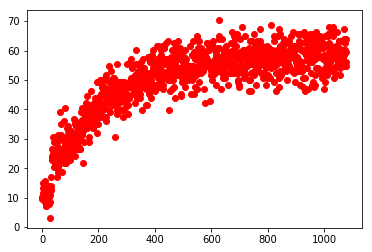

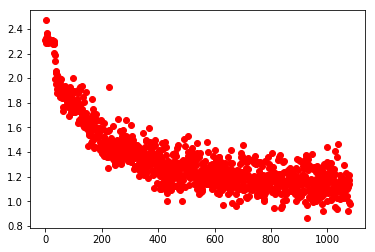

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

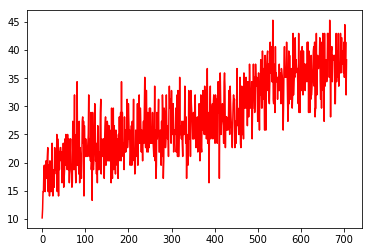

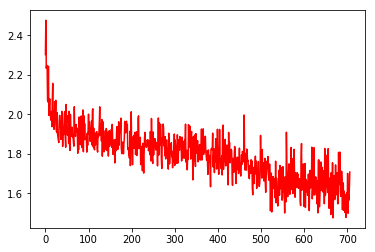

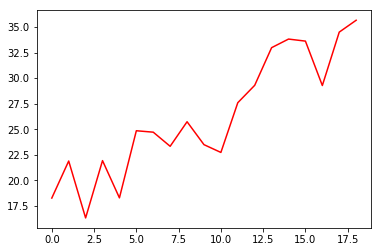

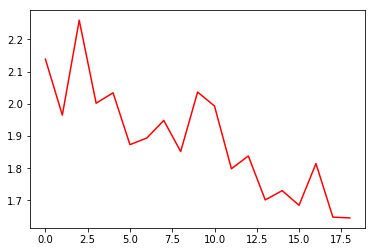

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()